In [1]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import glob
import numpy as np
cudnn.benchmark = True
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "1"  # Set the GPU 2 to use

In [2]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Filepath already exists. Skipping download.")
        return
    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n
    
def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)

In [3]:
dataset_directory = os.path.join(".", "datasets/cats-vs-dogs")

In [4]:
filepath = os.path.join(dataset_directory, "kagglecatsanddogs_3367a.zip")
download_url(
    url="https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip",
    filepath=filepath,
)
extract_archive(filepath)

Filepath already exists. Skipping download.


In [5]:
root_directory = os.path.join(dataset_directory, "PetImages")

cat_directory = os.path.join(root_directory, "Cat")
dog_directory = os.path.join(root_directory, "Dog")

cat_images_filepaths = glob.glob(cat_directory+'/*.jpg')
dog_images_filepaths = glob.glob(dog_directory+'/*.jpg')
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
# Remove Broken Image Files
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

In [6]:
random.seed(42)
random.shuffle(correct_images_filepaths)
train_list = correct_images_filepaths[:20000]
val_list = correct_images_filepaths[20000:-1000]
test_images = correct_images_filepaths[-1000:]
print(len(train_list), len(val_list), len(test_images))

20000 3946 1000


In [7]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

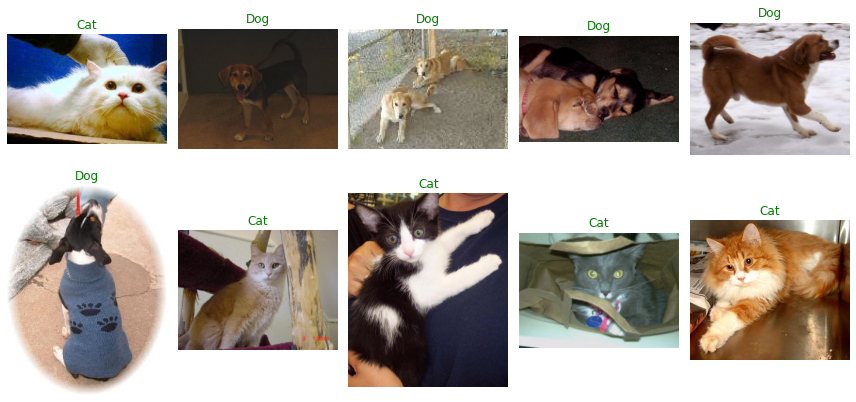

In [8]:
display_image_grid(test_images[:10])

In [9]:
class CatsVsDogsDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform
    
    def __len__(self):
        return len(self.images_filepaths)
    
    def __getitem__(self, idx):
        images_filepath = self.images_filepaths[idx]
        image = cv2.imread(images_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(images_filepath).split(os.sep)[-2] == "Cat":
            label = 1.0
        else:
            label = 0.0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [10]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128,width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = CatsVsDogsDataset(images_filepaths=train_list, transform=train_transform)

In [11]:
val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = CatsVsDogsDataset(images_filepaths=val_list, transform=val_transform)

In [12]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

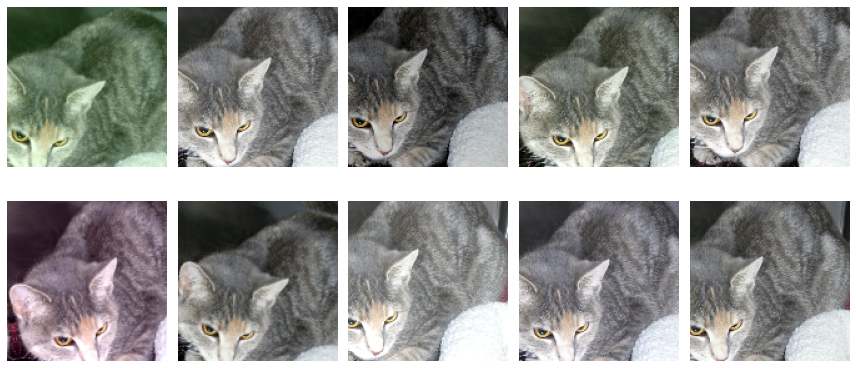

In [13]:
visualize_augmentations(train_dataset)

In [14]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [15]:
params = {
    "model": "resnet50",
    "device": "cuda",
    "lr": 0.004,
    "batch_size": 256,
    "num_workers": 8,
    "epochs": 150,
}

In [16]:
model = getattr(models, params["model"])(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 1)
)
model = model.to(params["device"])
criterion = nn.BCEWithLogitsLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

In [17]:
train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [18]:
total_step = len(train_loader) * params["epochs"]
scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
        optimizer,
        num_warmup_steps=total_step/50,
        num_cycles=6,
        num_training_steps=total_step
    )

In [19]:
mixup_alpha = 1.0

def mixup_data(x,y):
    lam = np.random.beta(mixup_alpha, mixup_alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self):
        super(LabelSmoothingCrossEntropy, self).__init__()
        
    def forward(self, y, targets, smoothing=0.1):
        confidence = 1. - smoothing
        log_probs = F.log_softmax(y, dim=-1)
        true_probs = torch.zeros_like(log_probs)
        true_probs.fill_(smoothing / (y.shape[1] - 1))
        true_probs.scatter_(1, targets.data.unsqueeze(1), confidence)
        return torch.mean(torch.sum(true_probs * -log_probs, dim=-1))

In [20]:
def lr_scheduler(optimizer, epoch):
    lr = params["lr"]
    if epoch >= 20:
        lr /= 10
    if epoch >= 40:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [21]:
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [22]:
def train(train_loader, model, criterion, optimizer,scheduler, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    #lr_scheduler(optimizer, epoch)
    train_loss = 0
    valid_loss = 0
    correct = 0
    total_cnt = 0
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
        #mixup
        images, target_a, target_b, lam = mixup_data(images, target)
        optimizer.zero_grad()
        
        output = model(images)
        # mixup criterion
        loss = mixup_criterion(criterion, output, target_a, target_b, lam)
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()
        _, predict = output.max(1)
        
        total_cnt += target.size(0)
        correct += (lam* predict.eq(target_a).sum().item() + (1-lam)*predict.eq(target_b).sum().item())
        metric_monitor.update("Loss", loss.item())

In [23]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [24]:
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer,scheduler, epoch, params)
    validate(val_loader, model, criterion, epoch, params)

100%|██████████| 79/79 [00:22<00:00,  3.51it/s]
Epoch: 1. Validation. Loss: 2.579 | Accuracy: 0.511: 100%|██████████| 16/16 [00:03<00:00,  4.94it/s]
100%|██████████| 79/79 [00:20<00:00,  3.88it/s]
Epoch: 2. Validation. Loss: 0.898 | Accuracy: 0.563: 100%|██████████| 16/16 [00:03<00:00,  5.15it/s]
100%|██████████| 79/79 [00:20<00:00,  3.87it/s]
Epoch: 3. Validation. Loss: 0.598 | Accuracy: 0.704: 100%|██████████| 16/16 [00:03<00:00,  5.19it/s]
100%|██████████| 79/79 [00:20<00:00,  3.90it/s]
Epoch: 4. Validation. Loss: 0.563 | Accuracy: 0.696: 100%|██████████| 16/16 [00:02<00:00,  5.40it/s]
100%|██████████| 79/79 [00:20<00:00,  3.90it/s]
Epoch: 5. Validation. Loss: 0.488 | Accuracy: 0.763: 100%|██████████| 16/16 [00:03<00:00,  5.13it/s]
100%|██████████| 79/79 [00:20<00:00,  3.89it/s]
Epoch: 6. Validation. Loss: 0.499 | Accuracy: 0.766: 100%|██████████| 16/16 [00:03<00:00,  5.25it/s]
100%|██████████| 79/79 [00:20<00:00,  3.86it/s]
Epoch: 7. Validation. Loss: 0.437 | Accuracy: 0.793: 100%|

# 150 Epoch + Adam + cosine hard restart(cycle 6), Training From Scratch

In [25]:
class CatsVsDogsInferenceDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image

test_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
test_dataset = CatsVsDogsInferenceDataset(images_filepaths=test_images, transform=test_transform)
test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [26]:
model = model.eval()
predicted_labels = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(params["device"], non_blocking=True)
        output = model(images)
        predictions = (torch.sigmoid(output) >= 0.5)[:, 0].cpu().numpy()
        predicted_labels += ["Cat" if is_cat else "Dog" for is_cat in predictions]

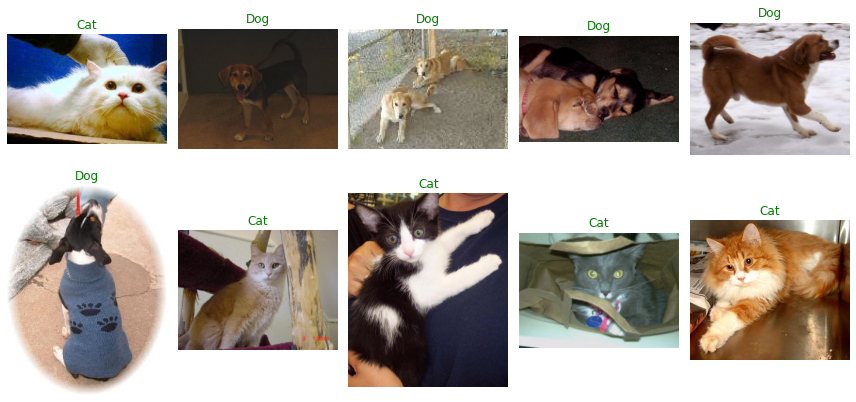

In [27]:
display_image_grid(test_images[:10], predicted_labels)